In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from model import VQTrEstimator

In [2]:
dataset = get_dataset("electricity")

In [4]:
estimator = VQTrEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*20,
    codebook_size=25,
    dim_head=8,
    nhead=2,
    depth=1,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",

    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    
    scaling=True,
  
    batch_size=256,
    num_batches_per_epoch=300,
    trainer_kwargs=dict(max_epochs=1, accelerator='gpu', devices=1, precision="bf16"),
)

In [5]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=512,
    cache_data=True,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | VQTrModel | 62.8 K
------------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0

Training: 0it [00:00, ?it/s]

Epoch 0, global step 300: 'train_loss' reached 8.40753 (best 8.40753), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_7/checkpoints/epoch=0-step=300.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [7]:
forecasts = list(forecast_it)

In [8]:
tss = list(ts_it)

In [9]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 5890.75it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [10]:
agg_metrics

{'MSE': 6758971.880967666,
 'abs_error': 14088997.19509697,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.9791060634424255,
 'MAPE': 0.13006721403291524,
 'sMAPE': 0.1353763470534241,
 'MSIS': 7.198228711528636,
 'QuantileLoss[0.1]': 5639215.47064215,
 'Coverage[0.1]': 0.1158025515502151,
 'QuantileLoss[0.2]': 9083555.568582967,
 'Coverage[0.2]': 0.22713618157543392,
 'QuantileLoss[0.3]': 11519013.508672476,
 'Coverage[0.3]': 0.34386589526776445,
 'QuantileLoss[0.4]': 13194765.495581416,
 'Coverage[0.4]': 0.45992805221777183,
 'QuantileLoss[0.5]': 14088997.268389855,
 'Coverage[0.5]': 0.5660695742471444,
 'QuantileLoss[0.6]': 14434858.81262429,
 'Coverage[0.6]': 0.6566718587746625,
 'QuantileLoss[0.7]': 13957128.4711641,
 'Coverage[0.7]': 0.7513907432131731,
 'QuantileLoss[0.8]': 12354273.759666216,
 'Coverage[0.8]': 0.8365969440735795,
 'QuantileLoss[0.9]': 9046191.961346885,
 'Coverage[0.9]': 0.910565939771547

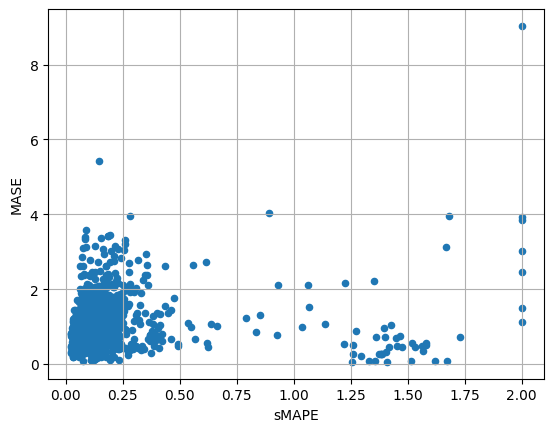

In [11]:
ts_metrics.plot(x='sMAPE', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

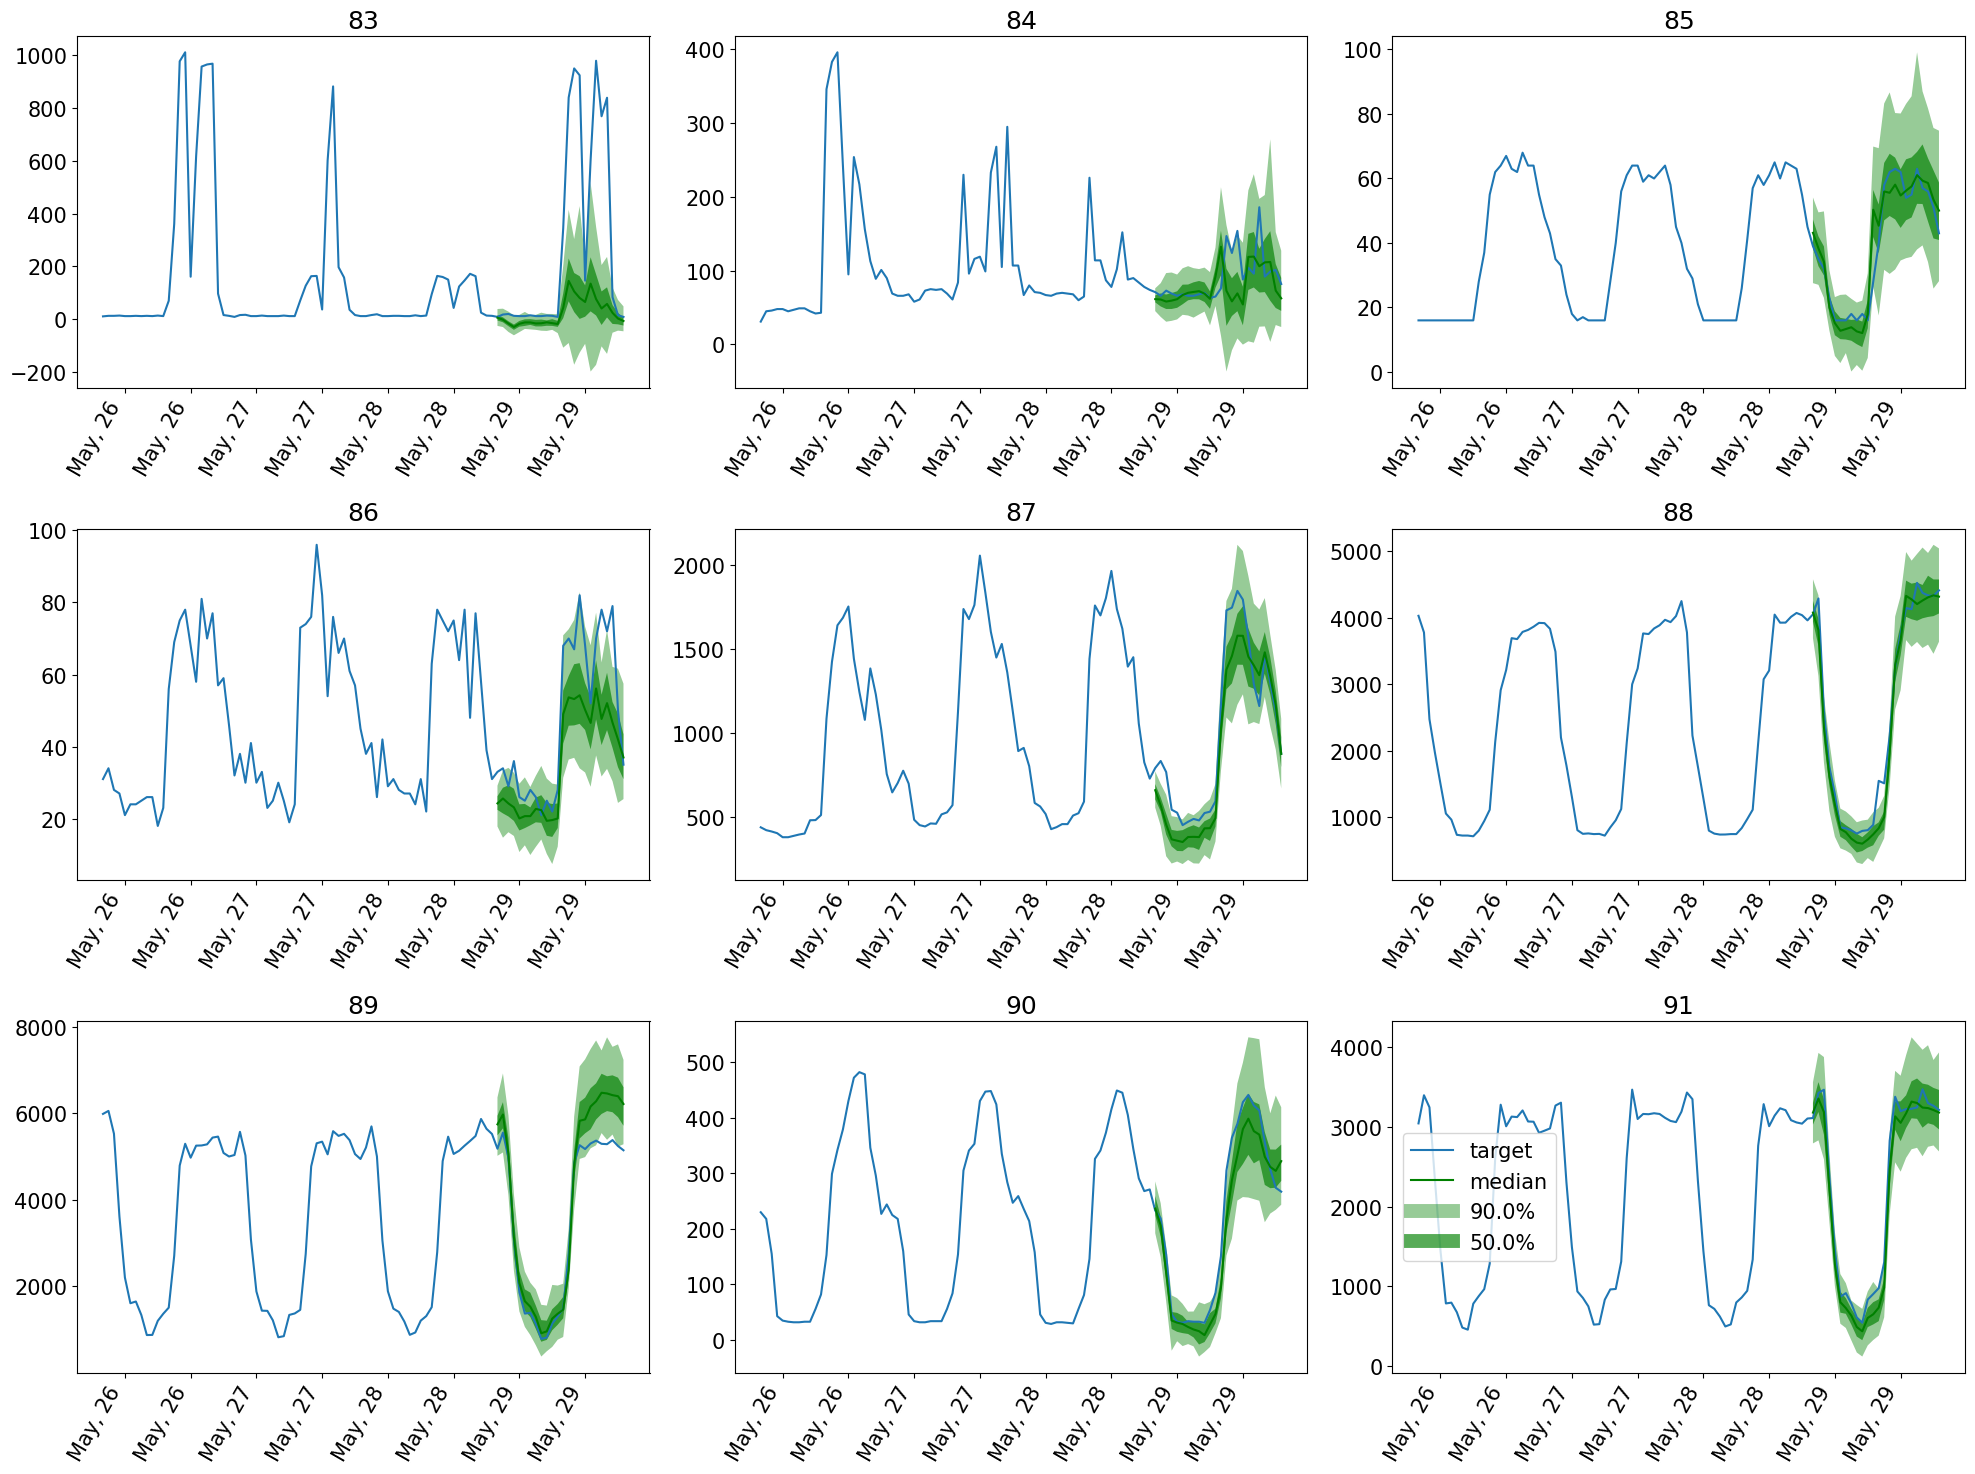

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 725, 725+9):
    ax = plt.subplot(3, 3, idx+1-725)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    plt.title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()